In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pickle  # For saving the model

In [2]:
# Load the dataset (replace 'path_to_your_data.csv' with your actual file path)
df = pd.read_csv('C:/Users/Administrator/Documents/kifiya/Week_6/df_woe.csv')
df = df.drop(columns=['TransactionId','SubscriptionId','AccountId','ProductId','BatchId',
                      'CustomerId','CurrencyCode','CountryCode','TransactionYear','TransactionStartTime',
                      'FraudResult','PricingStrategy','RFMS_Score','Amount'])
print(df.columns)


Index(['Value', 'ChannelId_woe', 'TransactionAmountStd',
       'AverageTransactionAmount', 'TotalTransactionAmount', 'RiskLabel',
       'TransactionDay', 'TransactionCount', 'TransactionHour',
       'ProductCategory_woe', 'ProviderId_woe', 'TransactionMonth',
       'Monetary_woe', 'Seniority_woe', 'Frequency_woe', 'Recency_woe'],
      dtype='object')


In [3]:
display(df.head())

,Value,ChannelId_woe,TransactionAmountStd,AverageTransactionAmount,TotalTransactionAmount,RiskLabel,TransactionDay,TransactionCount,TransactionHour,ProductCategory_woe,ProviderId_woe,TransactionMonth,Monetary_woe,Seniority_woe,Frequency_woe,Recency_woe
0,-0.072291,0.484515,-0.167016,-0.067623,0.170118,good,15,119,2,-1.690824,-2.906446,11,0.610597,0.440422,0.350225,-1.762156
1,-0.080251,-2.736867,-0.167016,-0.067623,0.170118,good,15,119,2,0.607033,-2.906446,11,0.610597,0.440422,0.350225,-1.762156
2,-0.076352,0.484515,-0.201209,-0.072568,0.165122,good,15,2,2,-1.690824,-2.906446,11,-1.548223,0.440422,-1.487822,1.065608
3,0.096648,0.484515,-0.008243,-0.008155,0.175567,good,15,38,3,0.607033,1.939442,11,-1.548223,0.440422,-0.535832,0.608133
4,-0.075183,-2.736867,-0.008243,-0.008155,0.175567,good,15,38,3,0.607033,-2.906446,11,-1.548223,0.440422,-0.535832,0.608133


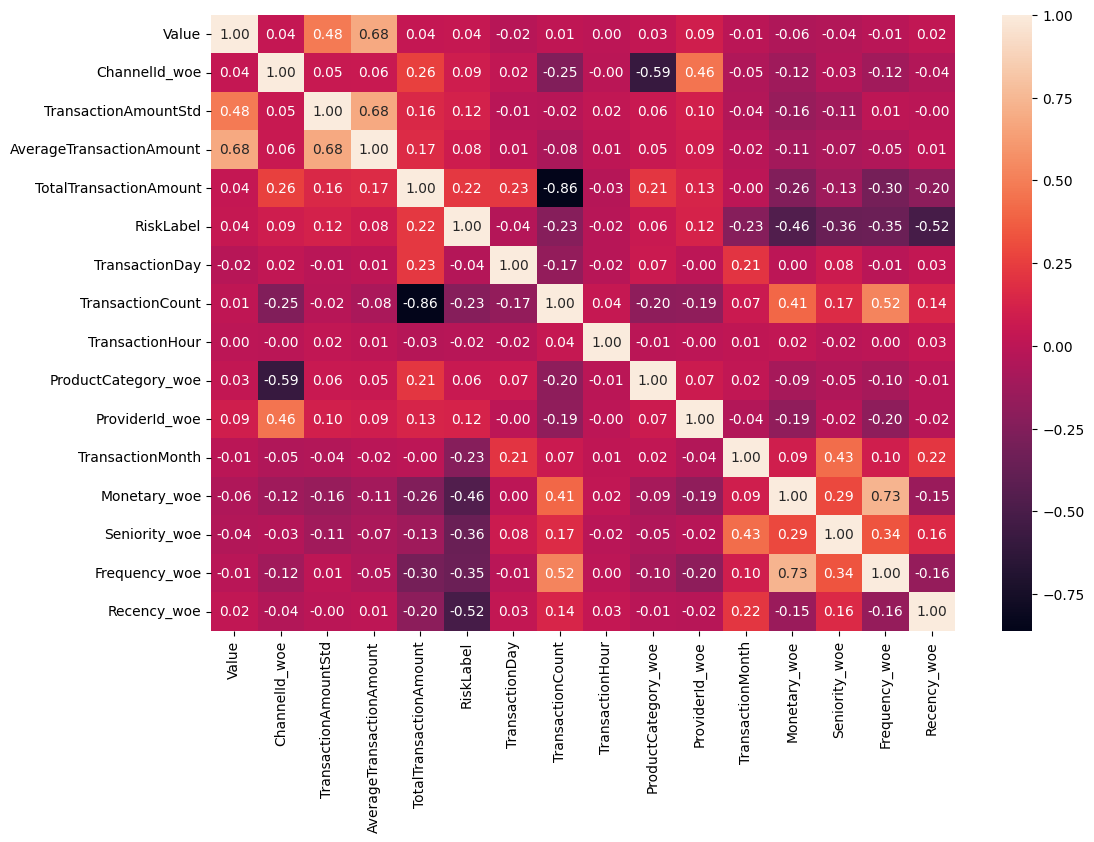

In [4]:
label_encoder = LabelEncoder()
# Fit and transform the RiskLabel column
df['RiskLabel'] = label_encoder.fit_transform(df['RiskLabel'])

plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.show()

In [5]:
# Function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    return roc_auc

In [6]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()
# Fit and transform the RiskLabel column
df['RiskLabel'] = label_encoder.fit_transform(df['RiskLabel'])

# Split data into features (X) and target variable (y)
X = df.drop(columns=['RiskLabel'])  # Features
y = df['RiskLabel']  # Target variable

In [7]:
# Feature scaling using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Logistic Regression with Lasso for feature selection
lasso = LogisticRegression(penalty='l1', solver='liblinear')  # L1 regularization
lasso.fit(X_scaled, y)

# Get the non-zero coefficients (selected features)
coef = pd.Series(lasso.coef_[0], index=X.columns)
selected_features_lasso = coef[coef != 0].index
print("Selected Features using Lasso Regression:")
print(selected_features_lasso)

Selected Features using Lasso Regression:
Index(['Value', 'ChannelId_woe', 'TransactionAmountStd',
       'AverageTransactionAmount', 'TotalTransactionAmount', 'TransactionDay',
       'TransactionCount', 'TransactionHour', 'ProductCategory_woe',
       'ProviderId_woe', 'TransactionMonth', 'Monetary_woe', 'Seniority_woe',
       'Frequency_woe', 'Recency_woe'],
      dtype='object')


c:\Users\Administrator\miniconda3\envs\jojo\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [8]:
# Filter the dataset with the selected features
X_selected = df[selected_features_lasso]


# Split the data: 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [9]:
# Initialize the models
rf_model = RandomForestClassifier(random_state=42)
gbm_model = GradientBoostingClassifier(random_state=42)

# Train the models
rf_model.fit(X_train, y_train)
gbm_model.fit(X_train, y_train)

print("Training completed for both Random Forest and Gradient Boosting models.")

Training completed for both Random Forest and Gradient Boosting models.


In [10]:
# Random Forest Parameter Grid
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search for Random Forest
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=5, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train, y_train)

print("Best Random Forest Parameters:", rf_grid_search.best_params_)

# Gradient Boosting Parameter Grid
gbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random Search for Gradient Boosting
gbm_random_search = RandomizedSearchCV(estimator=gbm_model, param_distributions=gbm_param_grid, n_iter=50, cv=5, random_state=42, n_jobs=-1, verbose=2)
gbm_random_search.fit(X_train, y_train)

print("Best GBM Parameters:", gbm_random_search.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Random Forest Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best GBM Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 7, 'learning_rate': 0.1}


In [11]:
# Function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    return roc_auc

In [12]:
# Evaluate Random Forest
print("Random Forest Performance:")
rf_roc_auc = evaluate_model(rf_model, X_test, y_test)

Random Forest Performance:
Accuracy: 0.9994
Precision: 0.9991
Recall: 0.9996
F1 Score: 0.9994
ROC-AUC: 1.0000


In [13]:
# Evaluate Gradient Boosting
print("\nGradient Boosting Performance:")
gbm_roc_auc = evaluate_model(gbm_model, X_test, y_test)


Gradient Boosting Performance:
Accuracy: 0.9545
Precision: 0.9325
Recall: 0.9793
F1 Score: 0.9553
ROC-AUC: 0.9956


In [14]:
cv_scores_rf = cross_val_score(rf_model, X, y, cv=5)
cv_scores_gbm = cross_val_score(gbm_model, X, y, cv=5)
print("\n")
print("Random Forest CV Average Score:", cv_scores_rf.mean())
print("GBM CV Average Score:", cv_scores_gbm.mean())



Random Forest CV Average Score: 0.8937616176623557
GBM CV Average Score: 0.844870680263738


In [21]:
# Create a Voting Classifier that combines both Random Forest and Gradient Boosting
voting_clf = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('gbm', gbm_model)
], voting='soft')  # Use 'soft' voting to average predicted probabilities

# Train the Voting Classifier
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('gbm',
                              GradientBoostingClassifier(random_state=42))],
                 voting='soft')

In [22]:
# Evaluate the ensemble model
print("\nVoting Classifier Performance:")
voting_roc_auc = evaluate_model(voting_clf, X_test, y_test)


Voting Classifier Performance:
Accuracy: 0.9975
Precision: 0.9977
Recall: 0.9972
F1 Score: 0.9974
ROC-AUC: 1.0000


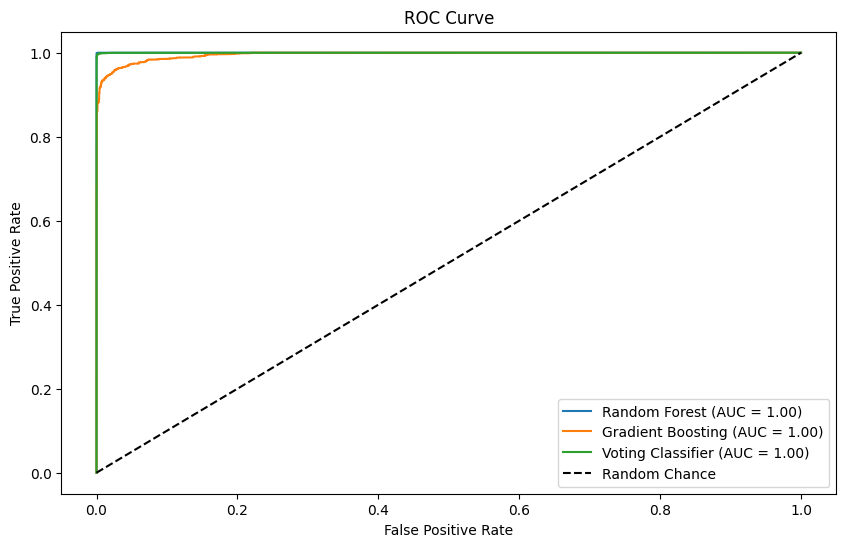

In [23]:
# Plot ROC Curve for all three models
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
fpr_gbm, tpr_gbm, _ = roc_curve(y_test, gbm_model.predict_proba(X_test)[:, 1])
fpr_voting, tpr_voting, _ = roc_curve(y_test, voting_clf.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_roc_auc:.2f})')
plt.plot(fpr_gbm, tpr_gbm, label=f'Gradient Boosting (AUC = {gbm_roc_auc:.2f})')
plt.plot(fpr_voting, tpr_voting, label=f'Voting Classifier (AUC = {voting_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [18]:

# Save the Voting Classifier to a .pkl file
with open('C:/Users/Administrator/Documents/kifiya/Week_6/final_model.pkl', 'wb') as file:
    pickle.dump(voting_clf, file)

print("Ensemble model saved as 'final_model.pkl'")

Ensemble model saved as 'final_model.pkl'
